<h1><center>SINr : manipulate and evaluate a SINr model</center></h1>
Github page : https://github.com/SINr-Embeddings/sinr/tree/main
    
Documentation : https://sinr-embeddings.github.io/sinr/_build/html/modules.html

Publications :
-  (https://hal.science/hal-03197434). Thibault Prouteau, Victor Connes, Nicolas Dugué, Anthony Perez,
   Jean-Charles Lamirel, et al.. SINr: Fast Computing of Sparse
   Interpretable Node Representations is not a Sin!. Advances in
   Intelligent Data Analysis XIX, 19th International Symposium on
   Intelligent Data Analysis, IDA 2021, Apr 2021, Porto, Portugal.
   pp.325-337,
-  (https://hal.science/hal-03770444). Thibault Prouteau, Nicolas Dugué, Nathalie Camelin, Sylvain Meignier.
   Are Embedding Spaces Interpretable? Results of an Intrusion Detection
   Evaluation on a Large French Corpus. LREC 2022, Jun 2022, Marseille,
   France.
-  (https://hal.science/hal-04321407). Simon Guillot, Thibault Prouteau, Nicolas Dugué.
   Sparser is better: one step closer to word embedding interpretability.
   IWCS 2023, Nancy, France.
-  (https://hal.science/hal-04398742). Anna Béranger, Nicolas Dugué, Simon Guillot, Thibault Prouteau.
   Filtering communities in word co-occurrence networks to foster the
   emergence of meaning. Complex Networks 2023, Menton, France.

In this notebook :
- Presentation of the model, sparsification, SINr-filtered method
- How does the model looks like ?
- How to evaluate performances with similarity task
- How to evaluate interpretability with the DistRatio
- How to use a SINr model for a categorization task
- How to load a Word2vec model with SINr library

For example of text preprocessing, model's training, sparsification and example of the SINr-Filtered method, see the notebook preprocess_train.

In [104]:
import sinr.graph_embeddings as ge
import sinr.text.evaluate as ev
import sinr.viz as viz
import sinr.text.preprocess as ppcs
from sklearn.datasets import fetch_20newsgroups
import xgboost as xgb

## Presentation of the model
In this notebook, we work with a model trained on BNC (British National Corpus, 90 million tokens). The model is available in the notebook repertory of the github project.

BNC is preprocessed to keep only:
- Lemmatized words
- Noun, adjective and verb
- Words occurring more than 20 times in the corpus

The model got trained with a gamma of 50.

It is a sparse model with at most 160 non zero values per word vectors.

The SINr-filtered method got applied (with a step of 100 and a diff_tol of 0.001):
- The dimensions with less than 600 non zero values got removed from the model
- The dimensions with more than 2900 non zero values got removed from the model

In [3]:
# load the sinrvec_bnc.pk file
model = ge.SINrVectors('bnc_spars20_filtered')
model.load('./sinrvec_bnc.pk')

## Explore the model's representations
In the SINr library we call :
- 'stereotypes' of a dimension words that have a non-zero value on the dimension
- 'descriptors' of a dimension words that constitute the community associated with the dimension

What are the words similar to 'milk'?

In [21]:
model.most_similar('milk')

{'object ': 'milk',
 'neighbors ': [('whey', 0.81),
  ('unpasteurised', 0.8),
  ('skim', 0.78),
  ('cow', 0.77),
  ('dairy', 0.76),
  ('pasteurise', 0.76),
  ('skimmed', 0.75),
  ('calve', 0.74),
  ('heifer', 0.73),
  ('suckler', 0.73),
  ('milking', 0.71),
  ('calf', 0.67),
  ('powdered', 0.67),
  ('cheese', 0.67),
  ('udder', 0.67),
  ('calving', 0.66),
  ('bull', 0.66),
  ('yoghurt', 0.66),
  ('pint', 0.63),
  ('dung', 0.62),
  ('herd', 0.62),
  ('curd', 0.61),
  ('butterfat', 0.61),
  ('terrier', 0.61),
  ('milker', 0.61),
  ('pail', 0.6),
  ('beef', 0.6),
  ('lactation', 0.59),
  ('meat', 0.59),
  ('condense', 0.58)]}

What is the community of which 'milk' is a member?

In [24]:
model.get_dimension_descriptors('milk')

{'dimension': 840, 'descriptors': [(0.42, 'skimmed'), (0.29, 'suckler'), (0.27, 'calve'), (0.26, 'heifer'), (0.16, 'unpasteurised'), (0.16, 'cow'), (0.14, 'pasteurise'), (0.12, 'dairy'), (0.11, 'calving'), (0.11, 'skim'), (0.1, 'milker'), (0.08, 'udder'), (0.08, 'bull'), (0.08, 'moo'), (0.08, 'milking'), (0.08, 'herd'), (0.08, 'calf'), (0.07, 'terrier'), (0.07, 'milk'), (0.06, 'dung'), (0.06, 'teat'), (0.06, 'byre'), (0.06, 'leaping'), (0.05, 'sire'), (0.05, 'powdered'), (0.05, 'yak'), (0.04, 'bullock'), (0.04, 'owd'), (0.04, 'milkmaid'), (0.04, 'condense')]}

In [25]:
# The community of a dimension can be asked by the id of the dimension aswell
model.get_dimension_descriptors_idx(840)

{'dimension': 840, 'descriptors': [(0.42, 'skimmed'), (0.29, 'suckler'), (0.27, 'calve'), (0.26, 'heifer'), (0.16, 'unpasteurised'), (0.16, 'cow'), (0.14, 'pasteurise'), (0.12, 'dairy'), (0.11, 'calving'), (0.11, 'skim'), (0.1, 'milker'), (0.08, 'udder'), (0.08, 'bull'), (0.08, 'moo'), (0.08, 'milking'), (0.08, 'herd'), (0.08, 'calf'), (0.07, 'terrier'), (0.07, 'milk'), (0.06, 'dung'), (0.06, 'teat'), (0.06, 'byre'), (0.06, 'leaping'), (0.05, 'sire'), (0.05, 'powdered'), (0.05, 'yak'), (0.04, 'bullock'), (0.04, 'owd'), (0.04, 'milkmaid'), (0.04, 'condense')]}

Which words have the highest values on this dimension?

In [26]:
model.get_dimension_stereotypes('milk')
# or model.get_dimension_stereotypes_idx(840)

{'dimension': 840, 'stereotypes': [(0.42, 'skimmed'), (0.29, 'suckler'), (0.27, 'calve'), (0.26, 'heifer'), (0.21, 'butterfat')]}

By which dimensions 'milk' is represented?

In [27]:
model.get_obj_stereotypes_and_descriptors('milk')
# see also get_obj_stereotypes and get_obj_descriptors

[{'dimension': 840,
  'value': True,
  'stereotypes': [(0.42, 'skimmed'), (0.29, 'suckler'), (0.27, 'calve')],
  'descriptors': [(0.42, 'skimmed'), (0.29, 'suckler'), (0.27, 'calve')]},
 {'dimension': 590,
  'value': True,
  'stereotypes': [(0.45, 'unsalted'), (0.4, 'pitta'), (0.35, 'wholemeal')],
  'descriptors': [(0.45, 'unsalted'), (0.4, 'pitta'), (0.35, 'wholemeal')]},
 {'dimension': 229,
  'value': True,
  'stereotypes': [(0.16, 'alcoholic'), (0.14, 'cola'), (0.14, 'fizzy')],
  'descriptors': [(0.16, 'alcoholic'), (0.14, 'fizzy'), (0.14, 'cola')]},
 {'dimension': 257,
  'value': True,
  'stereotypes': [(0.26, 'fructose'), (0.23, 'beet'), (0.18, 'cornflour')],
  'descriptors': [(0.26, 'fructose'), (0.23, 'beet'), (0.18, 'cornflour')]},
 {'dimension': 593,
  'value': True,
  'stereotypes': [(0.23, 'shortbread'), (0.19, 'eclair'), (0.18, 'preheated')],
  'descriptors': [(0.23, 'shortbread'),
   (0.19, 'eclair'),
   (0.17, 'buttercream')]}]

You can compare words with the module viz :

In [29]:
sinr_viz = viz.SINrViz(model)

{704, 1, 1281, 902, 335, 1426, 82, 724, 854, 30, 1056, 1191, 1192, 1065, 299, 951, 376, 826}


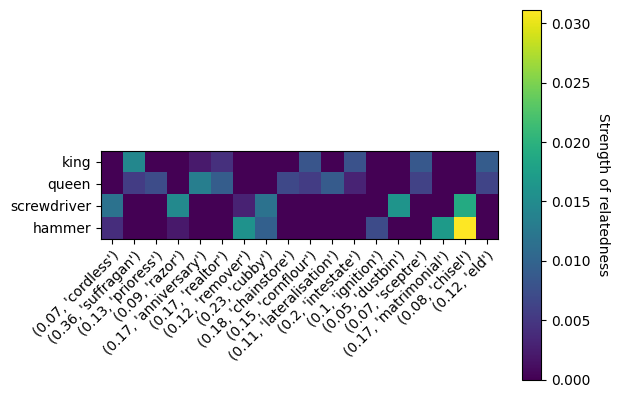

In [97]:
sinr_viz.compare_stereotypes(["king", "queen", "screwdriver", "hammer"], topk_dim=5)

## Similarity task : evaluate model's performances

With the library several similarity data sets are available : MEN, WS353, SCWS and SimLex (665, 999, 222 and 111).
You can fetch the dataset of your choice and evaluate the similarity of your model :

In [68]:
men = ev.fetch_data_MEN()
ev.eval_similarity(model, men)

eval similarity:   0%|          | 0/3000 [00:00<?, ?it/s]

1 missing words


0.7101779663902481

Or you can directly evaluate your model with MEN, WS353 and SCWS :

In [69]:
ev.similarity_MEN_WS353_SCWS(model)

eval similarity:   0%|          | 0/3000 [00:00<?, ?it/s]

1 missing words


eval similarity:   0%|          | 0/353 [00:00<?, ?it/s]

0 missing words


eval similarity:   0%|          | 0/1994 [00:00<?, ?it/s]

15 missing words


{'MEN': 0.7101779663902481,
 'WS353': 0.5719125743645842,
 'SCWS': 0.5707449776963844}

## DistRatio : evaluate model's interpretability

In [70]:
ev.dist_ratio(model)

  0%|          | 0/1431 [00:00<?, ?it/s]

  0%|          | 0/1431 [00:00<?, ?it/s]

2.650840230782654

## Text categorization task

Get datas with labels, for example, datas from the 20 Newsgroups dataset

In [99]:
datas_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=['alt.atheism', 'soc.religion.christian'])
X_test = datas_test.data
y_test = datas_test.target

datas_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=['alt.atheism', 'soc.religion.christian'])
X_train = datas_train.data
y_train = datas_train.target

Preprocess documents as you preprocess the corpus to train the model

In [100]:
# First, make raw files with a separator between each document
separator = '#DOC#'

with open('./train_#DOC#.txt', 'w+') as file:
    for x in X_train:
        file.write(separator)
        file.write(x)
file.close()

with open('./test_#DOC#.txt', 'w+') as file:
    for x in X_test:
        file.write(separator)
        file.write(x)
file.close()

In [101]:
# Then, make vrt files to be able to preprocess the text as you want
vrt_maker = ppcs.VRTMaker(ppcs.Corpus(ppcs.Corpus.REGISTER_WEB,
                                  ppcs.Corpus.LANGUAGE_EN,
                                  './train_#DOC#.txt'),
                                  ".", n_jobs=8)
vrt_maker.do_txt_to_vrt(separator=separator)
docs_train = ppcs.extract_text('./train_#DOC#.vrt', min_length_doc=-1)

vrt_maker = ppcs.VRTMaker(ppcs.Corpus(ppcs.Corpus.REGISTER_WEB,
                                  ppcs.Corpus.LANGUAGE_EN,
                                  './test_#DOC#.txt'),
                                  ".", n_jobs=8)
vrt_maker.do_txt_to_vrt(separator=separator)
docs_test = ppcs.extract_text('./test_#DOC#.vrt', min_length_doc=-1)

2024-06-13 16:48:38,983 - do_txt_to_vrt - INFO - 1079lines to preprocess


  0%|          | 0/1079 [00:00<?, ?it/s]

2024-06-13 16:49:45,669 - do_txt_to_vrt - INFO - VRT-style file written in /export/home/lium/aberanger/sinr/notebooks/train_#DOC#.vrt


  0%|          | 0/392185 [00:00<?, ?it/s]

2024-06-13 16:49:56,172 - do_txt_to_vrt - INFO - 717lines to preprocess


  0%|          | 0/717 [00:00<?, ?it/s]

2024-06-13 16:50:47,000 - do_txt_to_vrt - INFO - VRT-style file written in /export/home/lium/aberanger/sinr/notebooks/test_#DOC#.vrt


  0%|          | 0/286318 [00:00<?, ?it/s]

Vectorize the documents with a SINrVectors object

In [102]:
X_train, y_train = ev.vectorizer(model, docs_train, y=y_train)
X_test, y_test = ev.vectorizer(model, docs_test, y=y_test)

Choose a classifier (default : XGBoost), fit the datas and get the score of the task on the test datas

In [106]:
clf = ev.clf_fit(X_train, y_train, clf=xgb.XGBClassifier())
ev.clf_score(clf, X_test, y_test)

0.7266081871345029

If you choose XGBoost, you can see the main dimensions used by the classifier

In [108]:
ev.clf_xgb_interpretability(model, clf, 'stereotypes', topk_dim=10, topk=5, importance_type='gain')

([{'dimension': 1133, 'stereotypes': [(0.14, 'mantis'), (0.09, 'supplication'), (0.07, 'thanksgiving'), (0.06, 'thankfulness'), (0.06, 'meditation')]},
  {'dimension': 257, 'stereotypes': [(0.26, 'fructose'), (0.23, 'beet'), (0.18, 'cornflour'), (0.16, 'granulated'), (0.16, 'caster')]},
  {'dimension': 619, 'stereotypes': [(0.19, 'bungee'), (0.13, 'bandwagon'), (0.09, 'ya'), (0.04, 'parachute'), (0.04, 'jumping')]},
  {'dimension': 31, 'stereotypes': [(0.07, 'genocidal'), (0.06, 'tsarist'), (0.06, 'authoritarian'), (0.06, 'totalitarian'), (0.05, 'repressive')]},
  {'dimension': 837, 'stereotypes': [(0.12, 'jerry'), (0.05, 'bodyshell'), (0.05, 'obsolescence'), (0.04, 'mw'), (0.04, 'basilican')]},
  {'dimension': 1264, 'stereotypes': [(0.08, 'fourpence'), (0.07, 'thruppence'), (0.06, 'threepence'), (0.06, 'sixpence'), (0.06, 'ninepence')]},
  {'dimension': 850, 'stereotypes': [(0.09, 'inhumation'), (0.07, 'cremate'), (0.07, 'hatchet'), (0.07, 'cemetery'), (0.06, 'churchyard')]},
  {'dime

## Load a Word2vec model to evaluate it and compare it to your SINr model

In [ ]:
w2v_model = ge.SINrVectors.w2v_model("my_word2vec_model")